In [17]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import os
import random
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.multitest import multipletests

def parse_genome(df):
    genome_id = df['#query'][0].split('_')[0]
    keggs = df['KEGG_ko'].replace('-', None).dropna()
    keggs = list(map(lambda x: x.split(','), keggs.values))
    keggs = sum(keggs, [])
    keggs = pd.DataFrame({'KEGG_ko': keggs})
    keggs['genome_id'] = genome_id
    return keggs

def to_sparse_matrix(func_df, genome_id='genome_id', kegg_id='KEGG_ko'):
    # create genome-specific index
    ogus = list(set(func_df[genome_id]))
    ogu_lookup = pd.Series(np.arange(0, len(ogus)), ogus)
    # create KEGG-specific index
    keggs = list(set(func_df[kegg_id]))
    kegg_lookup = pd.Series(np.arange(0, len(keggs)), keggs)
    # rename names as numbers
    ogu_id = func_df[genome_id].apply(lambda x: ogu_lookup.loc[x]).astype(np.int64)
    kegg_id = func_df[kegg_id].apply(lambda x: kegg_lookup.loc[x]).astype(np.int64)
    # assign the presence / absence of a gene
    func_df['count'] = 1
    c = func_df['count'].values
    # format into a matrix
    data = coo_matrix((c, (ogu_id, kegg_id)))
    ko_ogu = pd.DataFrame(data.todense(), index=ogus, columns=keggs)
    return ko_ogu

def btest(pa1, pa2, seed=0, return_proportions=False):
    """ Performs genome wide binomial test between two groups of taxa
    Parameters
    ----------
    df1 : pd.DataFrame
        Rows are taxa, columns are genes
    df2 : pd.DataFrame
        Rows are taxa, columns are genes
    Returns
    -------
    pd.Series : list of genes associated with df1
    pd.Series : list of genes associated with df2
    """
    np.random.seed(seed)
    random.seed(seed)
    #pa1 = df1 > 0
    #pa2 = df2 > 0
    idx = list(set(pa1.columns) | set(pa2.columns))
    idx.sort()
    pa1 = pa1.sum(axis=0).reindex(idx).fillna(0)
    pa2 = pa2.sum(axis=0).reindex(idx).fillna(0)
    n = pa1 + pa2
    obs = list(zip(list(pa1.values), list((pa2.values + 1) / (pa2 + 1).sum()), list(n.values)))
    pvals = pd.Series([binom_test(a, n, b, 'two-sided') for (a, b, n) in obs],
                      index=n.index)
    if return_proportions:
        res = pd.DataFrame({'groupA': pa1, 'groupB': pa2, 'pval': pvals})
        def relabel_f(x):
            if x['groupA'] < x['groupB']:
                return 'groupB'
            else:
                return 'groupA'
        res['side'] = res.apply(relabel_f, axis=1)
        return res

    return pvals

def log_pvalue(lr, alpha=0.1, filter=True):
    """ Converts pvalues to -log(pvalue)
    Also performs Boniferroni correction.
    """
    lr = lr.reset_index()
    # lr.columns = ['KEGG', 'pvalue']
    lr['-log(pvalue)'] = -np.log(lr['pvalue'] + 1e-200)
    res = multipletests(lr['pvalue'], method='fdr_bh', alpha=alpha)
    lr['pvalue_corrected'] = res[1]
    if filter:
        lr = lr.loc[res[0]]
        return lr
    return lr

In [47]:
#run only once to generate two columns file metadata_new 
# #parse genomes-all_metadata.tsv: get species names from Lineage and Species_rep
# metadata = pd.read_table('../../../../Downloads/genomes-all_metadata.tsv')
# metadata_new = metadata[['Lineage','Species_rep']]
# metadata_new['species'] = metadata_new['Lineage'].str.split(';').str[6]
# metadata_new['Species'] = metadata_new['species'].str.split('__').str[1]
# metadata_new = metadata_new[['Species','Species_rep']]
# metadata_new.to_csv('../table/eggNOG_species_rep.txt', sep = '\t', index = False)

In [6]:
metadata_new = pd.read_table('../table/eggNOG_species_rep.txt')

In [125]:
#load tables
table_t2d = pd.read_table('../table/QinT2D_deseq2_all.txt')
table_cd = pd.read_table('../table/Franzosa_CD_deseq2_all.txt')
table_asd = pd.read_table('../table/Dan_n_Wang_ASD_deseq2_all.txt')

#negative: more abundant in cases
table_t2d_negative = table_t2d.sort_values(by=['CI_95'],ascending=True).head(15)
table_cd_negative = table_cd.sort_values(by=['CI_95'],ascending=True).head(15)
table_asd_negative = table_asd.sort_values(by=['CI_95'],ascending=True).head(15)

#positive: more abundant in controls
table_t2d_positive = table_t2d.sort_values(by=['CI_5'],ascending=False).head(15)
table_cd_positive = table_cd.sort_values(by=['CI_5'],ascending=False).head(15)
table_asd_positive = table_asd.sort_values(by=['CI_5'],ascending=False).head(15)


In [84]:
table_asd_negative.head(15)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,CI_5,CI_95
1337,Dialister hominis,6187.511409,-4.181113,0.576714,-7.249886,4.171217e-13,1.610090e-10,-5.311452,-3.050774
3381,Veillonella_A seminalis,119.664533,-4.358195,0.739896,-5.890277,3.855483e-09,4.343066e-07,-5.808365,-2.908024
1665,Fusobacterium_A ulcerans,701.705065,-3.889730,0.517602,-7.514912,5.694920e-14,2.564612e-11,-4.904211,-2.875250
30,Acidaminococcus provencensis,162.655214,-3.364577,0.539050,-6.241678,4.329009e-10,6.156307e-08,-4.421095,-2.308058
2672,Ruminococcus_E sp900314705,1200.750099,-3.026203,0.378736,-7.990281,1.346315e-15,1.818871e-12,-3.768511,-2.283895
1284,Coprococcus eutactus_A,8476.513093,-3.103802,0.436964,-7.103106,1.219837e-12,3.103737e-10,-3.960236,-2.247369
1273,Collinsella stercoris,466.447118,-3.733789,0.868144,-4.300885,1.701171e-05,5.223367e-04,-5.435321,-2.032258
256,Bacteroides fragilis_A,234654.507787,-2.818828,0.414748,-6.796487,1.072009e-11,2.068978e-09,-3.631719,-2.005938
3406,Weissella confusa,100.216609,-3.603798,0.848476,-4.247375,2.162894e-05,6.352327e-04,-5.266781,-1.940815
1543,Eubacterium_R sp900767025,215.421788,-2.735705,0.419066,-6.528106,6.660645e-11,1.124816e-08,-3.557058,-1.914351


In [126]:
t2d_positive = list(table_t2d_positive['Unnamed: 0'])
t2d_negative = list(table_t2d_negative['Unnamed: 0'])
asd_positive = list(table_asd_positive['Unnamed: 0'])
asd_negative = list(table_asd_negative['Unnamed: 0'])

In [127]:
t2d_positive_rep = metadata_new[metadata_new['Species'].isin(t2d_positive)]
Species_rep_ids_t2d_positive = t2d_positive_rep['Species_rep'].drop_duplicates()
t2d_negative_rep = metadata_new[metadata_new['Species'].isin(t2d_negative)]
Species_rep_ids_t2d_negative = t2d_negative_rep['Species_rep'].drop_duplicates()

asd_positive_rep = metadata_new[metadata_new['Species'].isin(asd_positive)]
Species_rep_ids_asd_positive = asd_positive_rep['Species_rep'].drop_duplicates()
asd_negative_rep = metadata_new[metadata_new['Species'].isin(asd_negative)]
Species_rep_ids_asd_negative = asd_negative_rep['Species_rep'].drop_duplicates()


In [128]:
Species_rep_ids_asd_positive
Species_rep_ids_asd_negative
#why length = 101?

154     MGYG000000155
181     MGYG000000182
217     MGYG000000218
230     MGYG000000231
235     MGYG000000236
963     MGYG000000968
1051    MGYG000001057
1054    MGYG000001060
1318    MGYG000001327
1373    MGYG000001382
1700    MGYG000001709
2764    MGYG000002779
3414    MGYG000003437
3961    MGYG000003990
4057    MGYG000004086
Name: Species_rep, dtype: object

In [129]:
len(Species_rep_ids_asd_negative)

15

In [90]:
eggNOG_dir = 'http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue/'

In [91]:
eggNOG_dir

'http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue/'

In [130]:
!mkdir T2D_negative_15
!mkdir T2D_positive_15

In [131]:
for i in Species_rep_ids_t2d_negative:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O T2D_negative_15/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

--2022-12-08 15:43:51--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000001/MGYG000000161/genome/MGYG000000161_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 792993 (774K) [text/tab-separated-values]
Saving to: ‘T2D_negative_15/MGYG000000161_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  6%  338K 2s
    50K .......... .......... .......... .......... .......... 12%  679K 1s
   100K .......... .......... .......... .......... .......... 19% 33.2M 1s
   150K .......... .......... .......... .......... .......... 25%  663K 1s
   200K .......... .......... .......... .......... .......... 32%  684K 1s
   250K .......... .......... .......... .......... .......... 38%  702K 1s
   300K .......... .......... .......... .......... .......... 45% 27.3M 1s
 

   400K .......... .......... .......... .......... .......... 74%  679K 0s
   450K .......... .......... .......... .......... .......... 82%  674K 0s
   500K .......... .......... .......... .......... .......... 90%  666K 0s
   550K .......... .......... .......... .......... .......... 99% 31.1M 0s
   600K ......                                                100% 85.9K=0.8s

2022-12-08 15:43:57 (748 KB/s) - ‘T2D_negative_15/MGYG000001440_eggNOG.tsv’ saved [620578/620578]

--2022-12-08 15:43:57--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000015/MGYG000001517/genome/MGYG000001517_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 665221 (650K) [text/tab-separated-values]
Saving to: ‘T2D_negative_15/MGYG000001517_eggNOG.tsv’

     0K .......... .......... .......... ..........

   450K .......... .......... .......... .......... .......... 61%  677K 0s
   500K .......... .......... .......... .......... .......... 67%  686K 0s
   550K .......... .......... .......... .......... .......... 74%  143M 0s
   600K .......... .......... .......... .......... .......... 80%  679K 0s
   650K .......... .......... .......... .......... .......... 86%  680K 0s
   700K .......... .......... .......... .......... .......... 92%  676K 0s
   750K .......... .......... .......... .......... .......... 98%  689K 0s
   800K ........                                              100% 29.7M=1.0s

2022-12-08 15:44:03 (783 KB/s) - ‘T2D_negative_15/MGYG000002469_eggNOG.tsv’ saved [828342/828342]

--2022-12-08 15:44:03--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000027/MGYG000002744/genome/MGYG000002744_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.1

In [132]:
#download the eggNOG tsv files
for i in Species_rep_ids_t2d_positive:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O T2D_positive_15/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

--2022-12-08 15:44:14--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000002/MGYG000000209/genome/MGYG000000209_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857429 (837K) [text/tab-separated-values]
Saving to: ‘T2D_positive_15/MGYG000000209_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  5%  337K 2s
    50K .......... .......... .......... .......... .......... 11%  677K 2s
   100K .......... .......... .......... .......... .......... 17% 63.2M 1s
   150K .......... .......... .......... .......... .......... 23%  678K 1s
   200K .......... .......... .......... .......... .......... 29%  677K 1s
   250K .......... .......... .......... .......... .......... 35%  682K 1s
   300K .......... .......... .......... .......... .......... 41%  141M 1s
 

   250K .......... .......... .......... .......... .......... 77%  663K 0s
   300K .......... .......... .......... .......... .......... 90% 96.5M 0s
   350K .......... .......... .......... ......               100%  507K=0.5s

2022-12-08 15:44:20 (749 KB/s) - ‘T2D_positive_15/MGYG000000784_eggNOG.tsv’ saved [396253/396253]

--2022-12-08 15:44:20--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000010/MGYG000001071/genome/MGYG000001071_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 615537 (601K) [text/tab-separated-values]
Saving to: ‘T2D_positive_15/MGYG000001071_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  8%  333K 2s
    50K .......... .......... .......... .......... .......... 16%  672K 1s
   100K .......... .......... .......... ..........

   600K .......... .......... .......... .......... .......... 76%  691K 0s
   650K .......... .......... .......... .......... .......... 82%  670K 0s
   700K .......... .......... .......... .......... .......... 88%  686K 0s
   750K .......... .......... .......... .......... .......... 94%  696K 0s
   800K .......... .......... .......... .......... .......... 99% 50.2M 0s
   850K                                                       100% 10.6K=1.0s

2022-12-08 15:44:26 (826 KB/s) - ‘T2D_positive_15/MGYG000002609_eggNOG.tsv’ saved [870944/870944]

--2022-12-08 15:44:26--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000026/MGYG000002631/genome/MGYG000002631_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 875614 (855K) [text/tab-separated-values]
Saving to: ‘T2D_positive_15/MG

   850K .......... .......... .......... .......... .......... 92%  687K 0s
   900K .......... .......... .......... .......... .......... 97%  674K 0s
   950K .......... .......... ..                              100%  118M=1.2s

2022-12-08 15:44:31 (823 KB/s) - ‘T2D_positive_15/MGYG000004431_eggNOG.tsv’ saved [995718/995718]



In [92]:
!mkdir ASD_negative_15
!mkdir ASD_positive_15

In [93]:
for i in Species_rep_ids_asd_negative:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O ASD_negative_15/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

--2022-12-08 14:51:14--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000001/MGYG000000155/genome/MGYG000000155_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 826422 (807K) [text/tab-separated-values]
Saving to: ‘ASD_negative_15/MGYG000000155_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  6%  341K 2s
    50K .......... .......... .......... .......... .......... 12%  680K 2s
   100K .......... .......... .......... .......... .......... 18% 60.5M 1s
   150K .......... .......... .......... .......... .......... 24%  682K 1s
   200K .......... .......... .......... .......... .......... 30%  680K 1s
   250K .......... .......... .......... .......... .......... 37%  674K 1s
   300K .......... .......... .......... .......... .......... 43%  174M 1s
 

   600K .......... .......... .......... .......... .......... 47%  687K 1s
   650K .......... .......... .......... .......... .......... 51% 97.3M 1s
   700K .......... .......... .......... .......... .......... 55%  668K 1s
   750K .......... .......... .......... .......... .......... 58%  668K 1s
   800K .......... .......... .......... .......... .......... 62%  681K 1s
   850K .......... .......... .......... .......... .......... 66%  682K 1s
   900K .......... .......... .......... .......... .......... 69% 30.5M 1s
   950K .......... .......... .......... .......... .......... 73%  689K 0s
  1000K .......... .......... .......... .......... .......... 77%  676K 0s
  1050K .......... .......... .......... .......... .......... 80%  666K 0s
  1100K .......... .......... .......... .......... .......... 84%  693K 0s
  1150K .......... .......... .......... .......... .......... 88% 74.9M 0s
  1200K .......... .......... .......... .......... .......... 91%  677K 0s
  1250K ....

HTTP request sent, awaiting response... 200 OK
Length: 644381 (629K) [text/tab-separated-values]
Saving to: ‘ASD_negative_15/MGYG000001382_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  7%  339K 2s
    50K .......... .......... .......... .......... .......... 15%  677K 1s
   100K .......... .......... .......... .......... .......... 23% 28.8M 1s
   150K .......... .......... .......... .......... .......... 31%  682K 1s
   200K .......... .......... .......... .......... .......... 39%  691K 1s
   250K .......... .......... .......... .......... .......... 47%  671K 0s
   300K .......... .......... .......... .......... .......... 55%  190M 0s
   350K .......... .......... .......... .......... .......... 63%  692K 0s
   400K .......... .......... .......... .......... .......... 71%  656K 0s
   450K .......... .......... .......... .......... .......... 79%  678K 0s
   500K .......... .......... .......... .......... .......... 87%  678K 0s
   550K ....

   150K .......... .......... .......... .......... .......... 54%  683K 0s
   200K .......... .......... .......... .......... .......... 68%  683K 0s
   250K .......... .......... .......... .......... .......... 82%  680K 0s
   300K .......... .......... .......... .......... .......... 96%  136M 0s
   350K .......... ...                                        100%  192K=0.5s

2022-12-08 14:51:31 (708 KB/s) - ‘ASD_negative_15/MGYG000004086_eggNOG.tsv’ saved [372722/372722]



In [94]:
for i in Species_rep_ids_asd_positive:
    os.system("wget '{}/{}/{}/genome/{}_eggNOG.tsv' -O ASD_positive_15/{}_eggNOG.tsv".format(eggNOG_dir, i[:-2], i, i, i))

--2022-12-08 14:51:31--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000000/MGYG000000081/genome/MGYG000000081_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000564 (977K) [text/tab-separated-values]
Saving to: ‘ASD_positive_15/MGYG000000081_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  5%  341K 3s
    50K .......... .......... .......... .......... .......... 10%  673K 2s
   100K .......... .......... .......... .......... .......... 15% 58.6M 1s
   150K .......... .......... .......... .......... .......... 20%  687K 1s
   200K .......... .......... .......... .......... .......... 25%  675K 1s
   250K .......... .......... .......... .......... .......... 30%  664K 1s
   300K .......... .......... .......... .......... .......... 35% 44.9M 1s


    50K .......... .......... .......... .......... ..........  8%  680K 2s
   100K .......... .......... .......... .......... .......... 12% 79.5M 2s
   150K .......... .......... .......... .......... .......... 16%  673K 1s
   200K .......... .......... .......... .......... .......... 21%  670K 1s
   250K .......... .......... .......... .......... .......... 25%  670K 1s
   300K .......... .......... .......... .......... .......... 29% 75.8M 1s
   350K .......... .......... .......... .......... .......... 33%  690K 1s
   400K .......... .......... .......... .......... .......... 38%  668K 1s
   450K .......... .......... .......... .......... .......... 42%  691K 1s
   500K .......... .......... .......... .......... .......... 46%  677K 1s
   550K .......... .......... .......... .......... .......... 50% 99.6M 1s
   600K .......... .......... .......... .......... .......... 55%  680K 1s
   650K .......... .......... .......... .......... .......... 59%  678K 1s
   700K ....

   250K .......... .......... .......... .......... .......... 38%  681K 1s
   300K .......... .......... .......... .......... .......... 44%  149M 1s
   350K .......... .......... .......... .......... .......... 50%  677K 0s
   400K .......... .......... .......... .......... .......... 57%  666K 0s
   450K .......... .......... .......... .......... .......... 63%  643K 0s
   500K .......... .......... .......... .......... .......... 70%  663K 0s
   550K .......... .......... .......... .......... .......... 76% 71.7M 0s
   600K .......... .......... .......... .......... .......... 82%  675K 0s
   650K .......... .......... .......... .......... .......... 89%  679K 0s
   700K .......... .......... .......... .......... .......... 95%  679K 0s
   750K .......... .......... .......... .....                100%  113M=1.0s

2022-12-08 14:51:42 (812 KB/s) - ‘ASD_positive_15/MGYG000001410_eggNOG.tsv’ saved [804533/804533]

--2022-12-08 14:51:42--  http://ftp.ebi.ac.uk/pub/databases/me

   400K .......... .......... .......... .......... .......... 84%  885K 0s
   450K .......... .......... .......... .......... .......... 93%  676K 0s
   500K .......... .......... .......... ..                   100% 77.3M=0.7s

2022-12-08 14:51:48 (802 KB/s) - ‘ASD_positive_15/MGYG000002616_eggNOG.tsv’ saved [545244/545244]

--2022-12-08 14:51:48--  http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue//MGYG0000030/MGYG000003017/genome/MGYG000003017_eggNOG.tsv
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 735726 (718K) [text/tab-separated-values]
Saving to: ‘ASD_positive_15/MGYG000003017_eggNOG.tsv’

     0K .......... .......... .......... .......... ..........  6%  339K 2s
    50K .......... .......... .......... .......... .......... 13%  667K 1s
   100K .......... .......... .......... ..........

In [95]:
#ASD
df_list_p = []
for i in Species_rep_ids_asd_positive:
    f_name = 'ASD_positive_15/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)
genome_kegg_counts_p.to_csv('../table/genome_kegg_counts_p_ASD_15.txt', sep = '\t') 

df_list_n = []
for i in Species_rep_ids_asd_negative:
    f_name = 'ASD_negative_15/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_n.append(df_parsed)
    
df_cat_n = pd.concat(df_list_n, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_n)
genome_kegg_counts_n.to_csv('../table/genome_kegg_counts_n_ASD_15.txt', sep = '\t') 

#clean up
!mv ASD_negative_15/ ../../
!mv ASD_positive_15/ ../../

#compare controls and cases: for top 100 microbes
kegg_asd = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=False)
kegg_asd = pd.DataFrame({'pvalue': kegg_asd})
kegg_asd = kegg_asd.reset_index().rename(columns={'index': 'KEGG'})
kegg_asd = log_pvalue(kegg_asd, alpha=0.1)
kegg_asd.to_csv('../table/kegg_asd_15microbes.txt', sep = '\t')
kegg_asd.sort_values(by = ['pvalue'])

,index,KEGG,pvalue,-log(pvalue),pvalue_corrected
898,898,ko:K01992,6.521201e-189,433.313524,2.651520e-185
1255,1255,ko:K02761,4.312307e-188,431.424525,8.766920e-185
896,896,ko:K01990,4.633644e-185,424.444899,6.280132e-182
2081,2081,ko:K06147,3.555591e-184,422.407136,3.614259e-181
530,530,ko:K01223,1.159597e-179,412.014659,9.429841e-177
...,...,...,...,...,...
2365,2365,ko:K07099,2.820624e-03,5.870797,3.203536e-03
2352,2352,ko:K07079,2.820624e-03,5.870797,3.203536e-03
676,676,ko:K01611,4.403921e-03,5.425260,5.000375e-03
3481,3481,ko:K16209,6.335776e-03,5.061543,7.189859e-03


In [140]:
#T2D_15micorbes
df_list_p = []
for i in Species_rep_ids_t2d_positive:
    f_name = '../../T2D_positive_15/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)
genome_kegg_counts_p.to_csv('../table/genome_kegg_counts_p_T2D_15.txt', sep = '\t') 

df_list_n = []
for i in Species_rep_ids_t2d_negative:
    f_name = '../../T2D_negative_15/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_n.append(df_parsed)
    
df_cat_n = pd.concat(df_list_n, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_n)
genome_kegg_counts_n.to_csv('../table/genome_kegg_counts_n_T2D_15.txt', sep = '\t') 

#clean up
# !mv T2D_negative_15/ ../../
# !mv T2D_positive_15/ ../../

#compare controls and cases: for top 100 microbes
kegg_t2d = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=False)
kegg_t2d = pd.DataFrame({'pvalue': kegg_t2d})
kegg_t2d = kegg_t2d.reset_index().rename(columns={'index': 'KEGG'})
kegg_t2d = log_pvalue(kegg_t2d, alpha=0.1)
kegg_t2d.to_csv('../table/kegg_t2d_15microbes.txt', sep = '\t')
kegg_t2d.sort_values(by = ['pvalue'])

,index,KEGG,pvalue,-log(pvalue),pvalue_corrected
1380,1380,ko:K03406,1.101315e-270,460.517019,3.866716e-267
1271,1271,ko:K03088,4.754030e-216,460.517019,8.345699e-213
1911,1911,ko:K06147,4.407531e-194,445.218193,5.158281e-191
810,810,ko:K01990,4.770973e-180,412.902766,4.187721e-177
1274,1274,ko:K03091,3.055979e-168,385.717196,2.145909e-165
...,...,...,...,...,...
1172,1172,ko:K02796,3.019647e-02,3.500030,3.635795e-02
1149,1149,ko:K02757,3.252576e-02,3.425723,3.913569e-02
1148,1148,ko:K02756,3.252576e-02,3.425723,3.913569e-02
1147,1147,ko:K02755,4.820188e-02,3.032357,5.797767e-02


In [104]:
genome_kegg_counts_p

,ko:K02986,ko:K02939,ko:K14742,ko:K02405,ko:K07082,ko:K07713,ko:K02795,ko:K13503,ko:K06147,ko:K10117,...,ko:K18986,ko:K01101,ko:K04068,ko:K20444,ko:K02071,ko:K11387,ko:K06351,ko:K03789,ko:K03073,ko:K10004
MGYG000000081,1,1,1,0,1,0,0,0,3,0,...,0,0,0,0,1,1,0,1,1,0
MGYG000001696,1,1,1,0,1,0,9,0,19,0,...,1,1,1,1,3,0,0,2,1,0
MGYG000003836,1,2,2,0,1,0,0,0,0,0,...,0,0,1,0,2,0,0,1,1,1
MGYG000001401,1,2,1,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,1
MGYG000000247,1,1,0,0,1,0,1,0,10,0,...,0,0,1,3,1,0,0,0,1,0
MGYG000000238,1,1,1,1,1,0,3,0,20,1,...,0,1,1,0,4,0,0,2,1,0
MGYG000001321,1,1,0,0,1,1,0,1,2,0,...,0,1,1,1,0,0,0,0,1,0
MGYG000001410,1,1,2,0,1,0,0,0,0,0,...,0,0,1,1,1,0,0,1,1,1
MGYG000002372,2,1,1,0,1,0,6,0,10,1,...,0,0,1,0,0,0,0,1,1,0
MGYG000002485,0,1,1,0,1,0,0,0,4,0,...,0,0,1,0,2,0,0,2,0,0


In [142]:
kegg_t2d.loc[kegg_t2d['pvalue_corrected'] <= 0.001].to_csv('../table/kegg_t2d_15microbes_sig.txt', sep = '\t')

In [ ]:
#KEGG pathway annotation
#https://www.kegg.jp/kegg/mapper/reconstruct.html
#gut metabolic modules: Vieira et al 2016
#https://bioconductor.org/packages/release/bioc/html/keggorthology.html


In [143]:
kegg_asd_15microbes = pd.read_table('../table/ASD_15microbes_kegg_pathways.txt')
kegg_t2d_15microbes = pd.read_table('../table/T2D_15microbes_kegg_pathways.txt')

In [146]:
kegg_asd_15microbes

,Kegg_pathways,Number_of_genes
0,Metabolism,4798
1,Genetic Information Processing,237
2,Environmental Information Processing,539
3,Cellular Processes,227
4,Organismal Systems,78
5,Human Diseases,209


In [144]:
kegg_t2d_15microbes

,Kegg_pathways,Number_of_genes
0,Metabolism,3794
1,Genetic Information Processing,244
2,Environmental Information Processing,334
3,Cellular Processes,208
4,Organismal Systems,64
5,Human Diseases,152


<AxesSubplot:xlabel='Number_of_genes', ylabel='Kegg_pathways'>

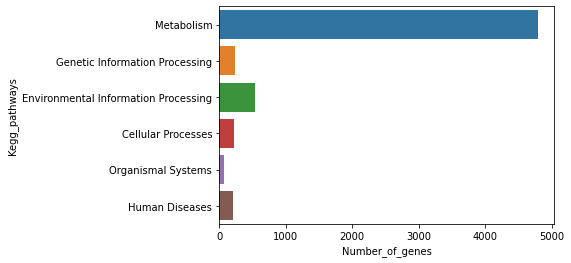

In [124]:
#plot pathways for asd
import seaborn as sns

sns.barplot(data = kegg_asd_15microbes, y = "Kegg_pathways", x = "Number_of_genes")

<AxesSubplot:xlabel='Number_of_genes', ylabel='Kegg_pathways'>

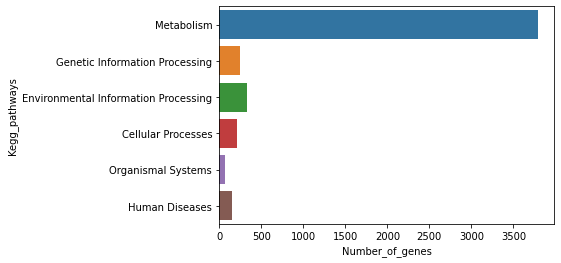

In [145]:
sns.barplot(data = kegg_t2d_15microbes, y = "Kegg_pathways", x = "Number_of_genes")

In [26]:
#kegg_t2d.sort_values(by = ['pvalue']).head(50)

In [27]:
#T2D
df_list_p = []
for i in Species_rep_ids_t2d_positive:
    f_name = 'T2D_positive/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_p.append(df_parsed)
    
df_cat_p = pd.concat(df_list_p, axis=0)
genome_kegg_counts_p = to_sparse_matrix(df_cat_p)
genome_kegg_counts_p.to_csv('../table/genome_kegg_counts_p_T2D.txt', sep = '\t') 


df_list_n = []
for i in Species_rep_ids_t2d_negative:
    f_name = 'T2D_negative/{}_eggNOG.tsv'.format(i)
    df_parsed = parse_genome(pd.read_table(f_name))
    df_list_n.append(df_parsed)
    
df_cat_n = pd.concat(df_list_n, axis=0)
genome_kegg_counts_n = to_sparse_matrix(df_cat_n)
genome_kegg_counts_n.to_csv('../table/genome_kegg_counts_n_T2D.txt', sep = '\t') 


In [28]:
!mv T2D_negative/ ../../
!mv T2D_positive/ ../../

In [33]:
#compare controls and cases: for top 100 microbes
kegg_t2d = btest(genome_kegg_counts_p, genome_kegg_counts_n, return_proportions=False)
kegg_t2d = pd.DataFrame({'pvalue': kegg_t2d})
kegg_t2d = kegg_t2d.reset_index().rename(columns={'index': 'KEGG'})
kegg_t2d = log_pvalue(kegg_t2d, alpha=0.1)
kegg_t2d.to_csv('../table/kegg_t2d.txt', sep = '\t')

In [34]:
kegg_t2d

,index,KEGG,pvalue,-log(pvalue),pvalue_corrected
0,0,ko:K00001,2.775592e-32,72.661859,6.347100e-32
1,1,ko:K00002,6.289484e-05,9.674046,9.381883e-05
2,2,ko:K00003,5.123586e-141,323.030643,2.781516e-140
3,3,ko:K00004,7.505432e-07,14.102469,1.244513e-06
4,4,ko:K00005,2.958079e-30,67.993013,6.622249e-30
...,...,...,...,...,...
5627,5627,ko:K22432,6.792365e-98,223.737540,2.795167e-97
5628,5628,ko:K22441,6.039021e-11,23.530194,1.082766e-10
5629,5629,ko:K22445,3.442794e-32,72.446440,7.860094e-32
5633,5633,ko:K22468,6.988462e-06,11.871250,1.093897e-05


In [31]:
kegg_t2d_sig = kegg_t2d.loc[(kegg_t2d['pvalue_corrected'] <= 0.001)]

In [35]:
kegg_t2d_sig

,index,KEGG,pvalue,-log(pvalue),pvalue_corrected
0,0,ko:K00001,2.775592e-32,72.661859,6.347100e-32
1,1,ko:K00002,6.289484e-05,9.674046,9.381883e-05
2,2,ko:K00003,5.123586e-141,323.030643,2.781516e-140
3,3,ko:K00004,7.505432e-07,14.102469,1.244513e-06
4,4,ko:K00005,2.958079e-30,67.993013,6.622249e-30
...,...,...,...,...,...
5627,5627,ko:K22432,6.792365e-98,223.737540,2.795167e-97
5628,5628,ko:K22441,6.039021e-11,23.530194,1.082766e-10
5629,5629,ko:K22445,3.442794e-32,72.446440,7.860094e-32
5633,5633,ko:K22468,6.988462e-06,11.871250,1.093897e-05


In [289]:
kegg_t2d_sig.sort_values(by = ['pvalue_corrected'])

,index,pvalue,-log(pvalue),pvalue_corrected
2859,ko:K07011,0.000000,460.517019,0.000000
642,ko:K01209,0.000000,460.517019,0.000000
673,ko:K01262,0.000000,460.517019,0.000000
1400,ko:K02529,0.000000,460.517019,0.000000
1353,ko:K02470,0.000000,460.517019,0.000000
...,...,...,...,...
258,ko:K00483,0.000845,7.075844,0.001205
1509,ko:K02782,0.000845,7.075844,0.001205
691,ko:K01303,0.000845,7.075844,0.001205
166,ko:K00285,0.000845,7.075844,0.001205


In [290]:
kegg_t2d.loc[(kegg_t2d['pvalue_corrected'] <= 0.001)]

,index,pvalue,-log(pvalue),pvalue_corrected
0,ko:K00001,2.775592e-32,72.661859,6.347100e-32
1,ko:K00002,6.289484e-05,9.674046,9.381883e-05
2,ko:K00003,5.123586e-141,323.030643,2.781516e-140
3,ko:K00004,7.505432e-07,14.102469,1.244513e-06
4,ko:K00005,2.958079e-30,67.993013,6.622249e-30
...,...,...,...,...
5627,ko:K22432,6.792365e-98,223.737540,2.795167e-97
5628,ko:K22441,6.039021e-11,23.530194,1.082766e-10
5629,ko:K22445,3.442794e-32,72.446440,7.860094e-32
5633,ko:K22468,6.988462e-06,11.871250,1.093897e-05


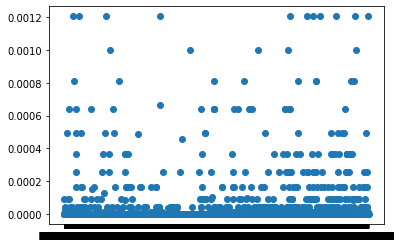

In [292]:
import matplotlib.pyplot as plt
x = kegg_t2d_sig['index']
y = kegg_t2d_sig['pvalue_corrected']
plt.scatter(x, y)
plt.show()

In [252]:
kegg_t2d.sort_values(by = ['pvalue']).head(50)

,index,pvalue,-log(pvalue),pvalue_corrected
1155,ko:K02078,0.0,460.517019,0.0
2786,ko:K06921,0.0,460.517019,0.0
397,ko:K00791,0.0,460.517019,0.0
1221,ko:K02238,0.0,460.517019,0.0
2859,ko:K07011,0.0,460.517019,0.0
2868,ko:K07025,0.0,460.517019,0.0
2913,ko:K07085,0.0,460.517019,0.0
394,ko:K00788,0.0,460.517019,0.0
2922,ko:K07098,0.0,460.517019,0.0
579,ko:K01091,0.0,460.517019,0.0
